In [1]:
# -*- coding: utf-8 -*-
#  Copyright 2023 Technical University of Denmark
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#  Authored by: Rémi Alexandre Laumont (DTU)
#  Edited by: Chao Zhang (DTU)
#  Reviewed by: Jakob Sauer Jørgensen (DTU)

# Image deblurring using Plug-and-Play priors
### Rémi Alexandre Laumont (real@dtu.dk)

_Plug-and-Play priors_ is an approach in image processing and computer vision that combines traditional image processing techniques with advanced machine learning methods. The idea is to "plug in" a learned prior or regularizer into an existing approach for image restoration tasks, such as deblurring. The learned priors can potentially capture complex image structures and textures, enabling better restoration results. This notebook explores the use of Plug-and-Play priors within the framework of CUQIpy.

__NOTICE__ To run this noteobook, you need PyTorch installed.

In [2]:
import sys
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt

import cuqi
from cuqi.model import LinearModel
from cuqi.distribution import Gaussian
from cuqi.problem import BayesianProblem

from cuqi.implicitprior import RegularizedGaussian
from cuqi.sampler import RegularizedLinearRTO
from utils import center_kernel, DnCNN, pytorch_denoiser, load_dncnn_weights

In [3]:
# Set seed
np.random.seed(0)

In [4]:
print("cuqi version: ", cuqi.__version__)

cuqi version:  0.8.0.post0.dev82


## Problem description

The goal of this notebook is to solve the inverse problem 

$$
y = Ax + n \ ,
$$

where $A$ is linear forward operator encoding a blur/convolution operation, $n$ is some additive noise with $n \sim \mathcal{N} (0, \sigma^2 I) $ and $y$ is the blurry observation of $y$.

**Goal:** Retrieve $x$ from $y$.

**Modelisation:**

- *Likelihood $P(Y|X=x)$:* Gaussian with density $p(y|X=x) \propto \exp (- \frac{1}{2\sigma^2} \| Ax - y\|_2^2)$.
- *Prior $P(X)$:* Gaussian with density $p(x) \propto \exp (- \frac{\gamma}{2} \| x\|_2^2)$.

It defines a posterior distribution $P(X|Y=y)$ with density $p(x|Y=y) \propto p(x) p(y|X=x)$.


**Method:** 

We propose to solve this inverse problem with the method of _Randomize, then optimize_ (RTO) by sampling from a **regularized posterior distribution** $p_{reg} \propto p(x|Y=y) \exp ( -g(x))$, where $g$ is a regularizer that will promote solutions with expected properties described by $g$. RTO is a sampling method which solves a perturbed optimization problem in order to generate one sample. If the forward operator $A$ is not full-ranked, we need to regularize the Gaussian likelihood by adding a quadratic term to the objective function. If the forward operator is linear, RTO reads as follows:

-   *Perturbed observation:* $\hat{y} = y + \sigma b_1$ with $b_1 \sim \mathcal{N}(0,  Id)$ <span style="color:red">(1)</span>
-   *Perturbed prior:* $\hat{c} = 0 + \frac{1}{\sqrt{\gamma}} b_2$ with $b_2 \sim \mathcal{N}(0, Id)$  <span style="color:red">(2)</span>
-   $x = \operatorname{argmin}_u \frac{1}{2\sigma^2} \|Au - \hat{y} \|_2^2 + \frac{\gamma}{2} \|u - \hat{c} \|_2^2 + g(u) $ <span style="color:red">(3)</span>

If $g$ describes a polyhedral set like the anisotropic TV or $L_1$ regularizer, then we have convergence guarantees. In this notebook, we will consider an implicit function possibly highly non-convex implicitly defined by a denoising algorithm.  

However defining a good regularizer $g$ is complicated. Here we choose to define the regularizer using a neural network denoiser $D_s$ approximating $\operatorname{prox}_g^{\delta}$. 
We hope that it will infer some regularization from the data it has been trained on. 

To solve <span style="color:red">(3)</span> we will use the PnP-Forward-Backward algortihm which reads $x_{k+1} = \operatorname{prox}_g^{\delta} (x_k - \delta \nabla f(x_k) ) = D_s(x_k - \delta \nabla f(x_k) )$ with $\delta >0$ and $f$ the posterior potential.


## Experiments

We start by importing the ground truth image `im`, defining our forward operator `A` and the (synthetic) noisy observation `y_data`.

### Ground truth image

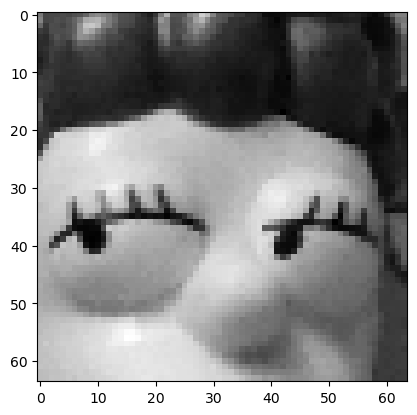

In [5]:
N = 64 # image size
l = 2 # box-filter kernel of size 2*l+1
lambd = 1000
sigma = np.sqrt(1/lambd) # standard deviation of the noise
gamma = 10 
sigma2 = sigma**2
gamma2 = gamma**2
device = "cuda:0"
# Loading the image
I = plt.imread("simpson_nb512.png")
im = I[2*N:3*N, N:2*N]
im /= np.max(im)

plt.figure()
plt.imshow(im, cmap = "gray")

### Linear Operator

In this experiment $A$ corresponds to a unifrom blur kernel of size $2l +1$. This linear operator is not full-ranked as you can see by computing its Fourier transform.

In [6]:
# Definition of the forward operator
l_k = 2*l + 1
h_ = np.ones((l_k, l_k))/(l_k)**2
k_uniform = np.zeros(im.shape)
k_uniform[0:l_k,0:l_k] = np.ones((l_k, l_k))/(l_k)**2
k_uniform = center_kernel(k_uniform, l)
h_fft = np.fft.fft2(k_uniform)
hc_fft = np.conj(h_fft)
A = lambda x : np.real(np.fft.ifft2(np.fft.fft2(x)*h_fft))
AT = lambda x : np.real(np.fft.ifft2(np.fft.fft2(x)*hc_fft))

# Specifying the geometry to match images
geometry = cuqi.geometry.Image2D((N,N)) # to work with 2D images
# CUQI linear operator
A_op = LinearModel(A, AT, range_geometry = geometry, domain_geometry = geometry)

### Observation

(-0.5, 63.5, 63.5, -0.5)

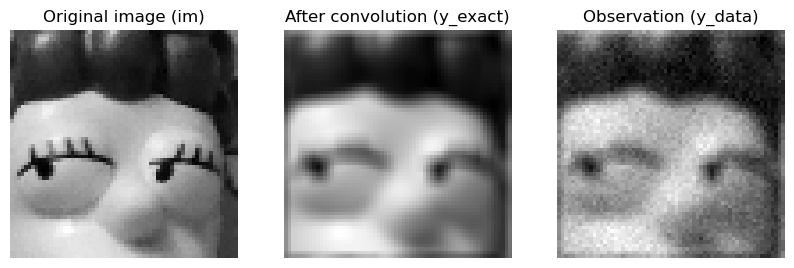

In [7]:
y_exact = A_op(im)

# Observation
# need to specify a prior --> Gaussian as not informative as possible
X_generation = Gaussian(0, gamma2, geometry = geometry)
Y_generation = Gaussian(A_op @ X_generation, sigma2, geometry = geometry)
y_data = Y_generation(X_generation = im).sample()

Y_generation_2 = Gaussian(im.flatten(), sigma2, geometry = geometry)
y_data_2 = Y_generation_2.sample()

fig = plt.figure(figsize = (10, 10))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(im, cmap = "gray")
ax1.axis("off")
ax1.set_title("Original image (im)")
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(im, cmap = "gray")
ax2.axis("off")
ax2.set_title("After convolution (y_exact)")
ax2.imshow(np.reshape(y_exact, (N, N)), cmap = "gray")
ax3 = fig.add_subplot(1, 3, 3)
ax3.imshow(np.reshape(y_data, (N, N)), cmap = "gray")
ax3.set_title("Observation (y_data)")
ax3.axis("off")

## Loading the Plug-and-Play regularizer

We first load the pre-trained denoiser which implicitly defines a regularizer. It has been trained at noise level $s=2.25$.

In [8]:
device = "cpu"
if device == "cpu":
    cuda = False
else:
    cuda = True
s = 2.25 # s = 2.0, 2.25, 2.5
n_ch = 1
if s == 2.5:
    ljr = 0.005
elif s == 2.25 or s == 2.0:
    ljr = 0.002
model = load_dncnn_weights(n_ch, s, ljr, device, path = 'pnp_denoiser/fine/ckpts/finetuned/')
Ds = lambda x, delta : pytorch_denoiser(x, model, device)

## Bayesian problem formulation

Now we are ready to define the Bayesian problem in CUQIpy.

In [9]:
X = RegularizedGaussian(np.zeros(N*N), gamma2, proximal = Ds)
Y = Gaussian(A_op @ X, sigma2, geometry = geometry)
BP = BayesianProblem(Y, X).set_data(Y = y_data)
posterior = BP.posterior

delta = 0.5/(1/sigma2 + 1/gamma2)
sampler = RegularizedLinearRTO(posterior, maxit = 200, stepsize = delta, abstol=1e-10)
samples = sampler.sample(250, 0)

Sample 250 / 250


With CUQIpy, we can easily check the mean, standard deviation and confidence interval the posterior samples.

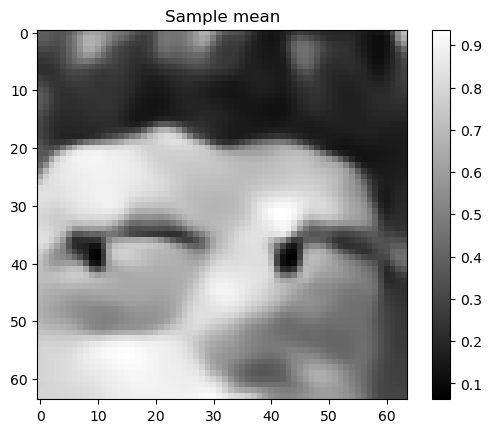

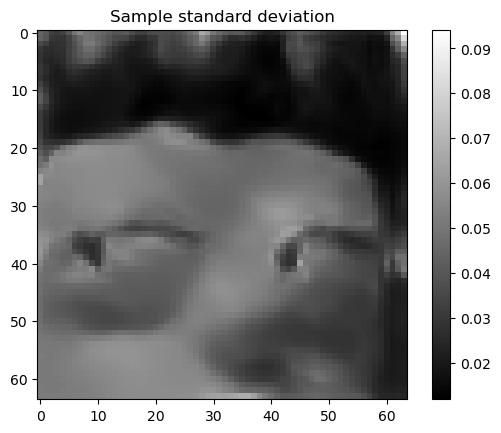

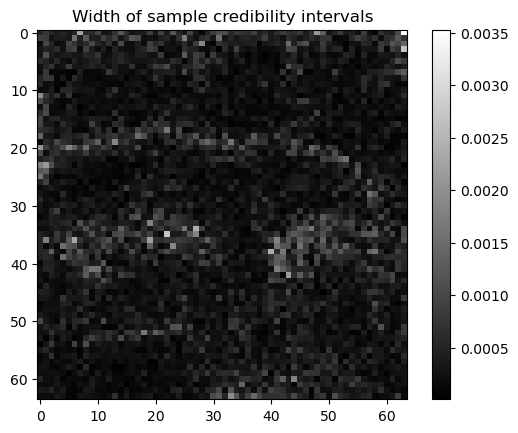

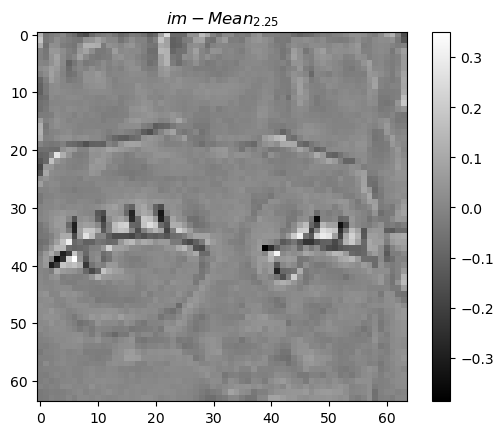

In [10]:
mean_225 = np.reshape(samples.mean(), (N, N))
std_225 = np.reshape(samples.std(), (N, N))

plt.figure()
IM_mean = samples.plot_mean()[0]
plt.colorbar(IM_mean)
plt.figure()
IM_std = samples.plot_std()[0]
plt.colorbar(IM_std)
plt.figure()
IM_ci = samples.plot_ci_width(0.95)[0]
plt.colorbar(IM_ci)

plt.figure()
plt.imshow(im - mean_225, cmap = 'gray')
plt.title(r"$im - Mean_{2.25}$")
plt.colorbar()

Now we compare the posterior means obtained from the two different denoisers.

And we show some samples from the posteriors.

## Summary
So far we have experimentally demonstrated the use of PnP priors with RTO. At this point, no convergence guarantees have been derived. A potential future work might be exploring [MYULA](https://epubs.siam.org/doi/abs/10.1137/16M1108340) in order to handle non-differentiable regularization for which we know the proximal operator.

